In [60]:
import pandas as pd
import requests
import json
from datetime import datetime
import requests, json, math
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [37]:
API_URL = "https://openapi.naver.com/v1/datalab/search"

In [44]:
HEADERS = {
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret,
    "Content-Type": "application/json"
}

In [45]:
category_keywords = {
    "글로벌경제": ["글로벌 경제", "세계 경제", "인플레이션", "연준", "FED", "달러 인덱스"],
    "금융":     ["금리", "기준금리", "예금", "대출 금리", "CD금리", "코픽스"],
    "부동산":   ["부동산", "전세", "매매가", "아파트 가격", "청약", "전월세"],
    "산업":     ["반도체", "자동차 산업", "배터리 산업", "제조업", "수출"],
    "일반":     ["물가", "실업률", "소비 지출", "경기지표", "경제성장률"],
    "증권":     ["주식", "코스피", "코스닥", "주가", "상한가", "공매도"]
}

In [46]:
START_DATE = "2024-01-01"
END_DATE   = "2024-12-31"
TIME_UNIT  = "month"       # 'date'|'week'|'month'
DEVICE     = "pc"          # 'pc'|'mo'|None
AGES       = ["2","3"]     # 20대/30대. 전체면 None
GENDER     = None          # 'm'|'f'|None

In [54]:
AGE_LABELS = {
    "1": "10대", "2": "20대", "3": "30대",
    "4": "40대", "5": "50대", "6": "60대+"
}
AGE_CODES = list(AGE_LABELS.keys())

In [55]:
def build_body(groups, age_code):
    body = {
        "startDate": START_DATE,
        "endDate": END_DATE,
        "timeUnit": TIME_UNIT,
        "keywordGroups": [{"groupName": k, "keywords": v} for k, v in groups],
        "ages": [age_code]
    }
    if DEVICE: body["device"] = DEVICE
    if GENDER: body["gender"] = GENDER
    return body

def fetch_batch(pairs, age_code):
    body = build_body(pairs, age_code)
    r = requests.post(API_URL, headers=HEADERS, data=json.dumps(body))
    r.raise_for_status()
    return r.json()

def fetch_all_for_age(age_code):
    items = list(category_keywords.items())
    batch_size = 5  # 데이터랩 제한
    results = []
    for i in range(0, len(items), batch_size):
        chunk = items[i:i+batch_size]
        data = fetch_batch(chunk, age_code)
        results.extend(data.get("results", []))
    return {"results": results}

In [56]:
def json_to_df(result_json, age_code):
    rows = []
    for grp in result_json.get("results", []):
        cat = grp.get("title")  # groupName으로 반환
        for d in grp.get("data", []):
            rows.append({
                "period": d["period"],
                "category": cat,
                "age_code": age_code,
                "age": AGE_LABELS[age_code],
                "ratio": d["ratio"]
            })
    return pd.DataFrame(rows)

In [57]:
all_long = []
for ac in AGE_CODES:
    res = fetch_all_for_age(ac)
    df = json_to_df(res, ac)
    all_long.append(df)

long_df = pd.concat(all_long, ignore_index=True).sort_values(["period","category","age_code"])
long_df.head()

,period,category,age_code,age,ratio
0,2024-01-01,글로벌경제,1,10대,40.00000
72,2024-01-01,글로벌경제,2,20대,23.74906
144,2024-01-01,글로벌경제,3,30대,13.33397
216,2024-01-01,글로벌경제,4,40대,6.55092
288,2024-01-01,글로벌경제,5,50대,5.02525


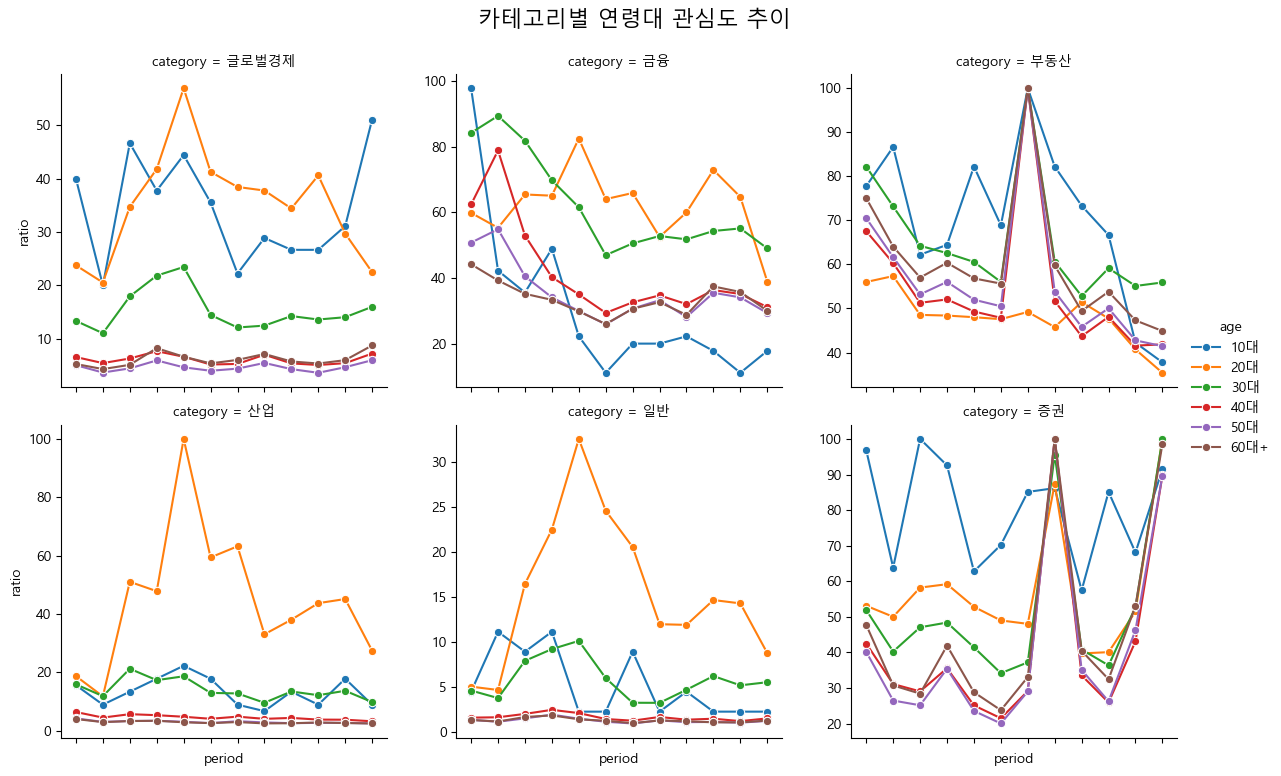

In [61]:
g = sns.FacetGrid(long_df, col="category", hue="age", col_wrap=3, sharey=False, height=4)
g.map(sns.lineplot, "period", "ratio", marker="o")
g.add_legend()
g.set_xticklabels(rotation=45)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("카테고리별 연령대 관심도 추이", fontsize=16)
plt.show()

In [63]:
avg_df = (long_df
          .groupby(["category","age"], as_index=False)["ratio"].mean()
          .pivot(index="category", columns="age", values="ratio")
          .sort_index())
avg_df

age,10대,20대,30대,40대,50대,60대+
category,,,,,,
글로벌경제,34.259255,35.219063,15.366688,6.080753,4.663726,6.146195
금융,30.555552,62.235494,62.247712,41.710623,35.569350,33.566477
부동산,70.370366,48.014683,65.199574,54.608962,56.485492,60.344823
산업,13.333327,44.915354,14.077157,4.531771,2.973492,2.886575
일반,5.185182,15.639777,5.774354,1.604497,1.230819,1.254336
증권,79.964535,57.422193,52.158053,42.195647,41.426669,46.581933


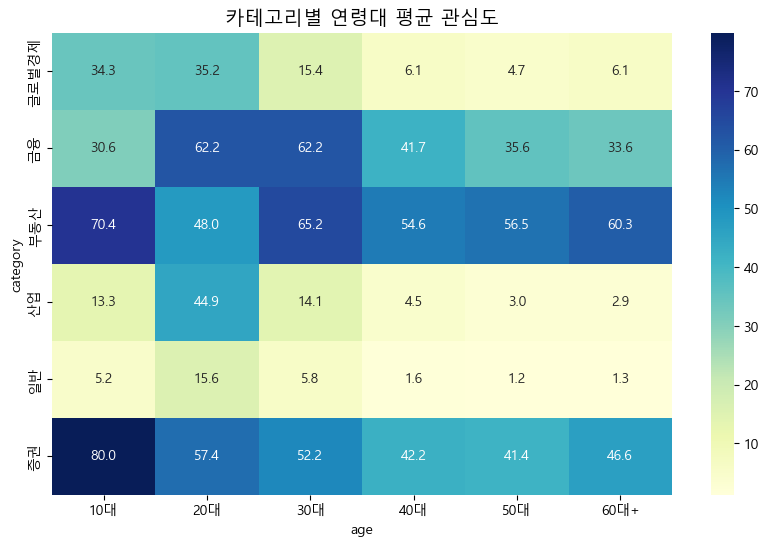

In [66]:
plt.figure(figsize=(10,6))
sns.heatmap(avg_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("카테고리별 연령대 평균 관심도", fontsize=14)
plt.show()